# 爬虫入门教程，以豆瓣电影排行为例

我自己也是爬虫小白，跟着别人的帖子学习。下面这个帖子我来介绍一下我目前学到的东西。我会稍微讲一下。

我们首先导入需要使用的包。如果有你还没有安装的包，你需要用 `pip install ...`，比如 `pip install beautifulsoup4`，`pip install pandas`，`pip install matplotlib` 等。

这个教程参照 [wistbean](https://github.com/wistbean) 的 [python爬虫08](https://vip.fxxkpython.com/?p=1871)。

In [35]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
%matplotlib inline

我们要爬的网站在这里：[豆瓣电影 Top 250](https://movie.douban.com/top250?start=0&filter=)。我们先来看一下第一页的内容：

In [36]:
url = 'https://movie.douban.com/top250?start=0&filter='
headers = {
    "user-agent": "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36",
}
response = requests.get(url=url, headers=headers)

`requests.get()` 这个函数里有两个参数，一个是 `url`，也就是豆瓣电影排行网址的第一页。`headers` 主要是用来迷惑被爬网站的，为了让我们的爬虫看起来更像正常的浏览器访问。`headers` 里面那一堆，不一定非要是自己浏览器的 `headers`。上面那行就是我从别人那里拿来的。

我们来看一下 `response` 的内容：

In [37]:
response

<Response [200]>

我们看到，只是显示了 `<Response [200]>`，表示访问成功，但并没有显示具体的内容。要显示具体内容，需要：`response.text`。

其实，用 `response.content` 也可以，但这里用 `text` 更好，具体请参考：https://stackoverflow.com/a/17011420

In [38]:
# response.text

我们需要用 `BeautifulSoup` 来解析上面的内容：

In [39]:
html = response.text
soup = BeautifulSoup(html, 'html.parser')
# soup

上面的结构就比刚才未解析之前的要清晰多了。如果你仔细看上面的内容，往下翻，就能看到我们想要的内容被包在了 `<ol class="grid_view">` 和 接近页尾的 `</ol>` 之间。如果你再仔细看，每一部电影的内容，都被包在了 `<li>` 和 `</li>` 之间。这好办：

In [40]:
list = soup.find(class_="grid_view").find_all("li")
# list

返回的内容是一个列表。这个列表里每一个元素是一个 `<li></li>`之间的内容，也就是一部电影。我们先来看一下第一部电影，看看如何从中获取我们想要的信息：

In [41]:
yi = list[0]
yi

<li>
<div class="item">
<div class="pic">
<em class="">1</em>
<a href="https://movie.douban.com/subject/1292052/">
<img alt="肖申克的救赎" class="" src="https://img9.doubanio.com/view/photo/s_ratio_poster/public/p480747492.jpg" width="100"/>
</a>
</div>
<div class="info">
<div class="hd">
<a class="" href="https://movie.douban.com/subject/1292052/">
<span class="title">肖申克的救赎</span>
<span class="title"> / The Shawshank Redemption</span>
<span class="other"> / 月黑高飞(港)  /  刺激1995(台)</span>
</a>
<span class="playable">[可播放]</span>
</div>
<div class="bd">
<p class="">
                            导演: 弗兰克·德拉邦特 Frank Darabont   主演: 蒂姆·罗宾斯 Tim Robbins /...<br/>
                            1994 / 美国 / 犯罪 剧情
                        </p>
<div class="star">
<span class="rating5-t"></span>
<span class="rating_num" property="v:average">9.7</span>
<span content="10.0" property="v:best"></span>
<span>2488993人评价</span>
</div>
<p class="quote">
<span class="inq">希望让人自由。</span>
</p>
</div>
</div>
</div>
</li>

我们想要的几个关键信息：电影名、排名、得分、评论人数、导演、发布年份、一句话介绍。通过观察上面的内容，你会发现大部分都非常好获取：

In [42]:
# 电影名：
yi.find(class_="title").string

'肖申克的救赎'

class 为 title 的有两个 <span>，我们用 `find` 的话，只是返回第一个，也就是中文电影名字。如果你两个都要，需要用 `find_all`。

In [43]:
# 排名
yi.find('em', attrs={'class': ""}).string

'1'

In [44]:
# 得分
yi.find(class_="rating_num").string

'9.7'

评价人数稍微复杂一些，因为 `<span>2488916人评价</span>` 并没有 `class`，我们无法直接获取。但还是有别的办法。通过观察，我们看到 `<span>2488916人评价</span>` 是 `<div class="star">` 这个 `div` 的一部分。`<div class="star">` 中有 4 个 `<span></span>`，评价人数是其中最后一个。我们需要做的是找出 `<div class="star">` 中所有的 `span`，提取出最后一个，然后提取出其中的数字，也就是评价人数：

In [45]:
pingjia_span = yi.find(class_="star").find_all('span')[-1]
pingjia_span

<span>2488993人评价</span>

In [46]:
# 评价人数
re.findall(r'\d+', pingjia_span.text)[0]

'2488993'

导演这个信息很麻烦，被包在了 `<p class="">` 里，很难提取出来。我现在用正则表达式还不熟练，就不在这上面花时间了，你如果感兴趣，可以搜索 “python 提取豆瓣前 250 电影“，一搜一大把，有很多人都把导演这部分信息提取出来了，你可以参考。当然是用正则表达式。

我现在只是把 `<p class="">` 里的内容提取出来：

In [47]:
yi.find('p', attrs={'class': ""}).text

'\n                            导演: 弗兰克·德拉邦特 Frank Darabont\xa0\xa0\xa0主演: 蒂姆·罗宾斯 Tim Robbins /...\n                            1994\xa0/\xa0美国\xa0/\xa0犯罪 剧情\n                        '

In [48]:
# 年份
re.findall(r'\d+', yi.find('p', attrs={'class': ""}).text)[0]

'1994'

In [49]:
# 一句话介绍
yi.find(class_="inq").string

'希望让人自由。'

我们看到基本上想要的信息都提取出来了。我们现在建一个 DataFrame，把第一页的数据提取一下。

In [50]:
# 建一个空的 df
# 除了上面的信息，我这里加了一个电影海报的图片地址 img
columns = ['name', 'img', 'ranking', 'score', 'population', 'info', 'year', 'quote']
df = pd.DataFrame(columns = columns)
df

,name,img,ranking,score,population,info,year,quote


我们回到第一页所有的电影信息：

In [51]:
# list

一个 `<li></li>` 就是一部电影。每部电影相关信息的获取方式是一样的，我们可以用一个 for 循环，把这一页上所有的电影的信息加入我们刚才创建的 df 里：

In [52]:
for i in list:
    item_name = i.find(class_="title").string
    item_img = i.find('a').find('img').get('src')
    item_ranking = i.find('div', attrs={'class': 'pic'}).find('em').string
    item_score= i.find(class_='rating_num').string
    item_population = re.findall(r'\d+', i.find(class_="star").find_all('span')[-1].text)[0]
    item_info = i.find('p', attrs={'class': ""}).text
    item_year = re.findall(r'\d+', i.find('p', attrs={'class': ""}).text)[0]
    item_quote = i.find(class_='inq').string 
    df.loc[df.shape[0]] = [item_name, item_img, item_ranking, item_score, item_population,
                           item_info, item_year, item_quote]
    print('爬取电影：' + item_ranking + ' | ' + item_name + ' | ' + item_score + ' | ' + item_quote)

爬取电影：1 | 肖申克的救赎 | 9.7 | 希望让人自由。
爬取电影：2 | 霸王别姬 | 9.6 | 风华绝代。
爬取电影：3 | 阿甘正传 | 9.5 | 一部美国近现代史。
爬取电影：4 | 这个杀手不太冷 | 9.4 | 怪蜀黍和小萝莉不得不说的故事。
爬取电影：5 | 泰坦尼克号 | 9.4 | 失去的才是永恒的。 
爬取电影：6 | 美丽人生 | 9.6 | 最美的谎言。
爬取电影：7 | 千与千寻 | 9.4 | 最好的宫崎骏，最好的久石让。 
爬取电影：8 | 辛德勒的名单 | 9.5 | 拯救一个人，就是拯救整个世界。
爬取电影：9 | 盗梦空间 | 9.3 | 诺兰给了我们一场无法盗取的梦。
爬取电影：10 | 忠犬八公的故事 | 9.4 | 永远都不能忘记你所爱的人。
爬取电影：11 | 星际穿越 | 9.3 | 爱是一种力量，让我们超越时空感知它的存在。
爬取电影：12 | 楚门的世界 | 9.3 | 如果再也不能见到你，祝你早安，午安，晚安。
爬取电影：13 | 海上钢琴师 | 9.3 | 每个人都要走一条自己坚定了的路，就算是粉身碎骨。 
爬取电影：14 | 三傻大闹宝莱坞 | 9.2 | 英俊版憨豆，高情商版谢耳朵。
爬取电影：15 | 机器人总动员 | 9.3 | 小瓦力，大人生。
爬取电影：16 | 放牛班的春天 | 9.3 | 天籁一般的童声，是最接近上帝的存在。 
爬取电影：17 | 无间道 | 9.3 | 香港电影史上永不过时的杰作。
爬取电影：18 | 疯狂动物城 | 9.2 | 迪士尼给我们营造的乌托邦就是这样，永远善良勇敢，永远出乎意料。
爬取电影：19 | 大话西游之大圣娶亲 | 9.2 | 一生所爱。
爬取电影：20 | 熔炉 | 9.3 | 我们一路奋战不是为了改变世界，而是为了不让世界改变我们。
爬取电影：21 | 教父 | 9.3 | 千万不要记恨你的对手，这样会让你失去理智。
爬取电影：22 | 当幸福来敲门 | 9.1 | 平民励志片。 
爬取电影：23 | 龙猫 | 9.2 | 人人心中都有个龙猫，童年就永远不会消失。
爬取电影：24 | 控方证人 | 9.6 | 比利·怀德满分作品。
爬取电影：25 | 怦然心动 | 9.1 | 真正的幸福是来自内心深处。


我们来看一下 `df` 是否更新：

In [53]:
df

,name,img,ranking,score,population,info,year,quote
0,肖申克的救赎,https://img9.doubanio.com/view/photo/s_ratio_p...,1,9.7,2488993,\n 导演: 弗兰克·德拉邦特 Fra...,1994,希望让人自由。
1,霸王别姬,https://img9.doubanio.com/view/photo/s_ratio_p...,2,9.6,1850389,\n 导演: 陈凯歌 Kaige Ch...,1993,风华绝代。
2,阿甘正传,https://img9.doubanio.com/view/photo/s_ratio_p...,3,9.5,1870418,\n 导演: 罗伯特·泽米吉斯 Rob...,1994,一部美国近现代史。
3,这个杀手不太冷,https://img9.doubanio.com/view/photo/s_ratio_p...,4,9.4,2033063,\n 导演: 吕克·贝松 Luc Be...,1994,怪蜀黍和小萝莉不得不说的故事。
4,泰坦尼克号,https://img9.doubanio.com/view/photo/s_ratio_p...,5,9.4,1832099,\n 导演: 詹姆斯·卡梅隆 Jame...,1997,失去的才是永恒的。
5,美丽人生,https://img9.doubanio.com/view/photo/s_ratio_p...,6,9.6,1146751,\n 导演: 罗伯托·贝尼尼 Robe...,1997,最美的谎言。
6,千与千寻,https://img9.doubanio.com/view/photo/s_ratio_p...,7,9.4,1951432,\n 导演: 宫崎骏 Hayao Mi...,2001,最好的宫崎骏，最好的久石让。
7,辛德勒的名单,https://img9.doubanio.com/view/photo/s_ratio_p...,8,9.5,956223,\n 导演: 史蒂文·斯皮尔伯格 St...,1993,拯救一个人，就是拯救整个世界。
8,盗梦空间,https://img9.doubanio.com/view/photo/s_ratio_p...,9,9.3,1797460,\n 导演: 克里斯托弗·诺兰 Chr...,2010,诺兰给了我们一场无法盗取的梦。
9,忠犬八公的故事,https://img9.doubanio.com/view/photo/s_ratio_p...,10,9.4,1234369,\n 导演: 莱塞·霍尔斯道姆 Las...,2009,永远都不能忘记你所爱的人。


接下来的任务就很简单了。第一页的网址是 `https://movie.douban.com/top250?start=0&filter=`，第二页是 `https://movie.douban.com/top250?start=25&filter=`，以此类推，最后一页是 `https://movie.douban.com/top250?start=250&filter=`，我们看到变化的只是 `start=`后面紧跟着的数字，我们把它弄成一个变量就好了：

In [54]:
def get_list(page):
    url = 'https://movie.douban.com/top250?start=' + str(page*25) + '&filter='
    headers = {
        "user-agent": "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36",
    }
    response = requests.get(url=url, headers=headers)
    html = response.text
    soup = BeautifulSoup(html, 'html.parser')
    list = soup.find(class_="grid_view").find_all("li")
    return list

In [55]:
def get_movie(list):
    for i in list:
        item_name = i.find(class_="title").string
        item_img = i.find('a').find('img').get('src')
        item_ranking = i.find('div', attrs={'class': 'pic'}).find('em').string
        item_score= i.find(class_='rating_num').string
        item_population = re.findall(r'\d+', i.find(class_="star").find_all('span')[-1].text)[0]
        item_info = i.find('p', attrs={'class': ""}).text
        item_year = re.findall(r'\d+', i.find('p', attrs={'class': ""}).text)[0]
        item_quote = i.find(class_='inq').string if i.find(class_='inq') != None else ""
        df.loc[df.shape[0]] = [item_name, item_img, item_ranking, item_score, item_population,
                           item_info, item_year, item_quote]
    return df

这里需要注意的是，`item_quote` 我稍微改了改。这是因为第 7 页的第一部电影 《寄生虫》没有一句话介绍。

In [56]:
columns = ['name', 'img', 'ranking', 'score', 'population', 'info', 'year', 'quote']
df = pd.DataFrame(columns = columns)
for i in range(0, 11):
    list = get_list(i)
    get_movie(list)

In [57]:
# df

我们看到 `df` 已经更新，全部数据已经拿到。如果需要，可以把 `df` 导出为 CSV:

In [58]:
df.to_csv(r'douban.csv', index=False)

我们来简单分析一下年份：

In [59]:
# 按年份把 df 分组：
# df.groupby('year').apply(display)

<AxesSubplot:title={'center':'Distribution of Release Year'}, xlabel='year'>

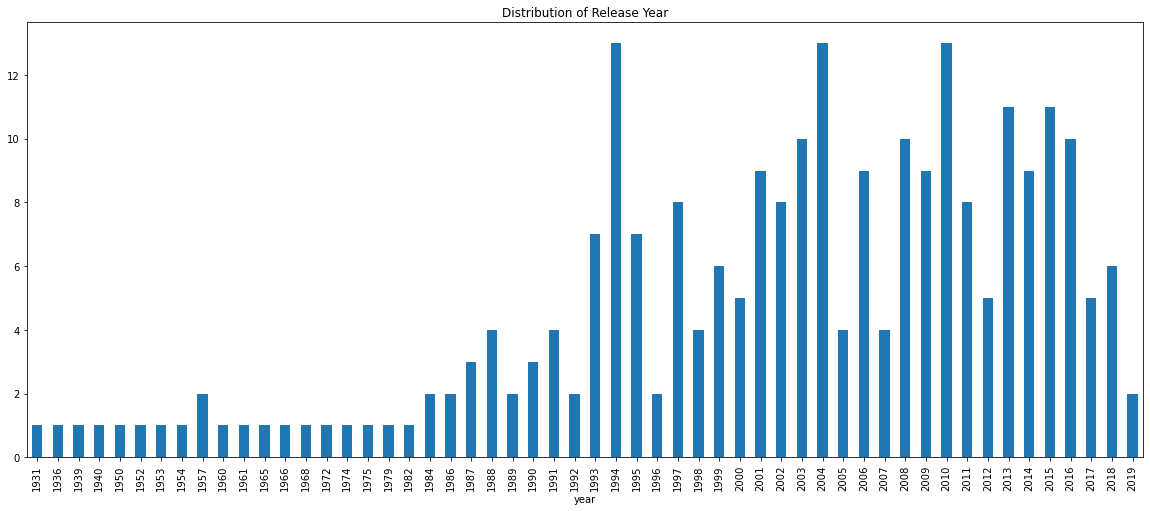

In [60]:
df.groupby('year')['year'].count().plot.bar(title="Distribution of Release Year", figsize=(20, 8))